# 16 PDEs: Crank-Nicholson Method 

See the [derivation of the Crank-Nicholson algorithm (PDF)](16_LectureNotes_CrankNicholson.pdf).

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

For 3D rotatable output:

In [ ]:
%matplotlib widget

For HTML/nbviewer output, use inline:

In [2]:
%matplotlib inline

## Crank-Nicholson implementation
We start with a straight-forward implementation that solves the implicit step with the standard linear algebra solver `numpy.linalg.solve()`.

The main problem is to set up the matrices $\mathsf{M}(\eta)$ (only has to be done once) and the right-hand side vector $\mathbf{b}$. In our problem, the boundaries of $\mathbf{b}$ do not change but it is easy to add time-varying boundary conditions as well by updating $\mathbf{b} = \mathbf{b}(t)$ in the loop.

To construct $\mathsf{M}(\eta)$ we use `np.diagflat()`: we build matrices for the upper, central, and lower diagonal and add them:

In [3]:
NM = 5
alpha = 99
np.diagflat(-np.ones(NM-1), -1) + alpha*np.diagflat(np.ones(NM), 0) + np.diagflat(-np.ones(NM-1), 1)

array([[99., -1.,  0.,  0.,  0.],
       [-1., 99., -1.,  0.,  0.],
       [ 0., -1., 99., -1.,  0.],
       [ 0.,  0., -1., 99., -1.],
       [ 0.,  0.,  0., -1., 99.]])

The full _Crank-Nicholson_ algorithm with the standard `np.linalg.solve()` solver:

In [4]:
import numpy as np

def CrankNicholson_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
                     step=20, verbose=True):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)

    if verbose:
        print("Nx = {0}, Nt = {1}".format(Nx, Nt))
        print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    #---------------------
    # M_eta * T[1:-1, j+1] = bT
    # M_eta * xT = bT
    # Nx-2 x Nx-2 matrix: tridiagonal
    NM = Nx - 2
    alpha = 2/eta + 2
    beta = 2/eta - 2
    M_eta = np.diagflat(-np.ones(NM-1), 1) \
            + np.diagflat(alpha * np.ones(NM), 0) \
            + np.diagflat(-np.ones(NM-1), -1)
    bT = np.zeros(NM)

    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        bT[:] = T[:-2] + beta*T[1:-1] + T[2:]
        # boundaries are special cases
        bT[0] += T[0]  #  + T[0,j+1]
        bT[-1] += T[-1] #  + T[-1,j+1]

        T[1:-1] = np.linalg.solve(M_eta, bT)

        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            if verbose:
                print("Iteration {0:5d}".format(jt), end="\r")
    else:
        if verbose:
            print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
        
    parameters = (Dx, Dt, step)
    return T_plot, parameters

In [5]:
T_plot, (Dx, Dt, step) = CrankNicholson_T(t_max=3000, Dx=0.02, Dt=2)

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


### Visualize 

In [6]:
def plot_T(T_plot, Dx, Dt, step):
    X, Y = np.meshgrid(range(T_plot.shape[0]), range(T_plot.shape[1]))
    Z = T_plot[X, Y]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(X*Dt*step, Y*Dx, Z)
    ax.set_xlabel(r"time $t$ (s)")
    ax.set_ylabel(r"position $x$ (m)")
    ax.set_zlabel(r"temperature $T$ (K)")
    fig.tight_layout()
    return ax

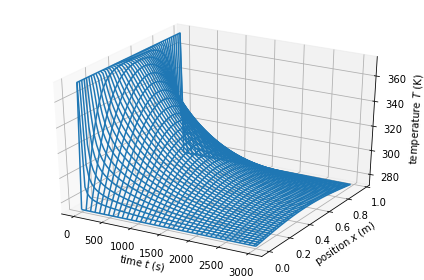

In [7]:
plot_T(T_plot, Dx, Dt, step)

Note that this also works with $\eta > 1/2$:

These were the settings at which leapfrog failed:

Nx = 99, Nt = 1500
eta = 1.9506172839506173
Completed  1499 iterations: t=2998 s


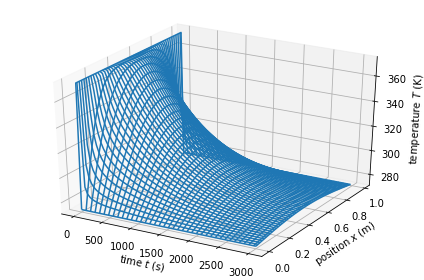

In [8]:
T_plot, (Dx, Dt, step) = CrankNicholson_T(t_max=3000, Dx=0.01, Dt=2)
plot_T(T_plot, Dx, Dt, step)

We can also take very large time steps – depending on the problem, this can be a huge time saver, e.g., if we're only interested in long time scale behavior:

Nx = 49, Nt = 150
eta = 4.8765432098765435
Completed   149 iterations: t=2980 s


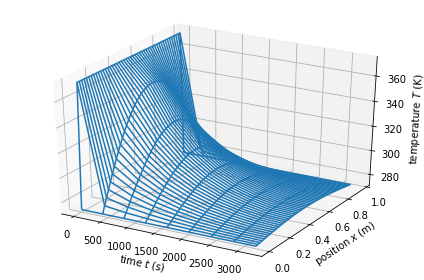

In [9]:
T_plot, (Dx, Dt, step) = CrankNicholson_T(t_max=3000, Dx=0.02, Dt=20)
plot_T(T_plot, Dx, Dt, step)

## Stability analysis
Von-Neumann stability analysis yields:

$$
|\xi(k)| = \left| \frac{1 - 2\eta\sin^2\frac{k\Delta x}{2}}{1 + 2\eta\sin^2\frac{k\Delta x}{2}} \right|
$$

Because $\sin^2\alpha \le 1$ it follows that the amplification factors

$$
|\xi(k)| \le 1
$$

for *all* $k$. Therefore, the Crank-Nicholson scheme is *stable for all combinations of $\Delta x$  and $\Delta t$*.

## Faster solutions 

### Using matrix inverse
We only need to calculate the matrix inverse of `M_eta` once and can then use

$$
\mathbf{x}_T = \mathsf{M}(\eta)^{-1} \mathbf{b}_T
$$

In [10]:
import numpy as np

def CrankNicholson_inverse_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
                     step=20, verbose=True):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)
    
    if verbose:
        print("Nx = {0}, Nt = {1}".format(Nx, Nt))
        print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    #---------------------
    # M_eta * T[1:-1, j+1] = bT
    # M_eta * xT = bT
    # Nx-2 x Nx-2 matrix: tridiagonal
    NM = Nx - 2
    alpha = 2/eta + 2
    beta = 2/eta - 2
    M_eta = np.diagflat(-np.ones(NM-1), 1) \
            + np.diagflat(alpha * np.ones(NM), 0) \
            + np.diagflat(-np.ones(NM-1), -1)
    bT = np.zeros(NM)
    
    inv_M_eta = np.linalg.inv(M_eta)

    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        bT[:] = T[:-2] + beta*T[1:-1] + T[2:]
        # boundaries are special cases
        bT[0] += T[0]  #  + T[0,j+1]
        bT[-1] += T[-1] #  + T[-1,j+1]

        T[1:-1] = np.dot(inv_M_eta, bT)

        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            if verbose:
                print("Iteration {0:5d}".format(jt), end="\r")
    else:
        if verbose:
            print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
        
    parameters = (Dx, Dt, step)
    return T_plot, parameters

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


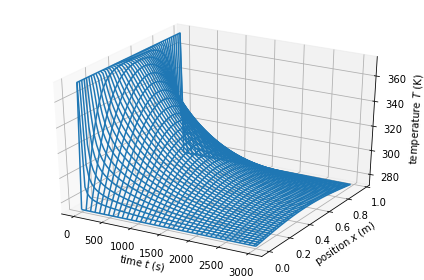

In [11]:
T_plot, (Dx, Dt, step) = CrankNicholson_inverse_T(t_max=3000, Dx=0.02, Dt=2)
plot_T(T_plot, Dx, Dt, step)

### Special routines for *banded* matrices
Tridiagonal matrices are a special (simple) case of *banded matrices*. **scipy** contains special, fast routines to solve matrix equations for banded matrices, namely [scipy.linalg.solve_banded()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html#scipy.linalg.solve_banded). The only difficulty is to format the input in a form suitable for the function:

In [12]:
import scipy.linalg

def solve_tridiagonal_banded(A, b):
    ab = extract_tridiag_ab(A)
    return scipy.linalg.solve_banded((1, 1), ab, b)

def extract_tridiag_ab(A):
    # extract diagonals and pad (as required for solve_banded())
    ud = np.insert(np.diag(A, 1), 0, 0)         # upper diagonal
    d = np.diag(A)                              # main diagonal
    ld = np.insert(np.diag(A, -1), len(d)-1, 0) # lower diagonal
    # matrix as required by solve_banded()
    ab = np.array([ud, d, ld])
    return ab
                       

Faster Crank-Nicholson:

In [13]:
import numpy as np
import scipy.linalg

def CrankNicholson_banded_T(L_rod=1, t_max=3000, Dx=0.02, Dt=2, T0=373, Tb=273,
                     step=20, verbose=True):
    Nx = int(L_rod // Dx)
    Nt = int(t_max // Dt)

    Kappa = 237 # W/(m K)
    CHeat = 900 # J/K
    rho = 2700  # kg/m^3

    eta = Kappa * Dt / (CHeat * rho * Dx**2)
    
    if verbose:
        print("Nx = {0}, Nt = {1}".format(Nx, Nt))
        print("eta = {0}".format(eta))

    T = np.zeros(Nx)
    T_plot = np.zeros((int(np.ceil(Nt/step)) + 1, Nx))

    # initial conditions
    T[1:-1] = T0
    # boundary conditions
    T[0] = T[-1] = Tb

    #---------------------
    # M_eta * T[1:-1, j+1] = bT
    # M_eta * xT = bT
    # Nx-2 x Nx-2 matrix: tridiagonal
    NM = Nx - 2
    alpha = 2/eta + 2
    beta = 2/eta - 2
    M_eta = np.diagflat(-np.ones(NM-1), 1) \
            + np.diagflat(alpha * np.ones(NM), 0) \
            + np.diagflat(-np.ones(NM-1), -1)
    bT = np.zeros(NM)
    
    M_eta_ab = extract_tridiag_ab(M_eta)

    t_index = 0
    T_plot[t_index, :] = T
    for jt in range(1, Nt):
        bT[:] = T[:-2] + beta*T[1:-1] + T[2:]
        # boundaries are special cases
        bT[0] += T[0]  #  + T[0,j+1]
        bT[-1] += T[-1] #  + T[-1,j+1]

        T[1:-1] = scipy.linalg.solve_banded((1, 1), M_eta_ab, bT)

        if jt % step == 0 or jt == Nt-1:
            t_index += 1
            T_plot[t_index, :] = T
            if verbose:
                print("Iteration {0:5d}".format(jt), end="\r")
    else:
        if verbose:
            print("Completed {0:5d} iterations: t={1} s".format(jt, jt*Dt))
        
    parameters = (Dx, Dt, step)
    return T_plot, parameters

Nx = 49, Nt = 1500
eta = 0.4876543209876543
Completed  1499 iterations: t=2998 s


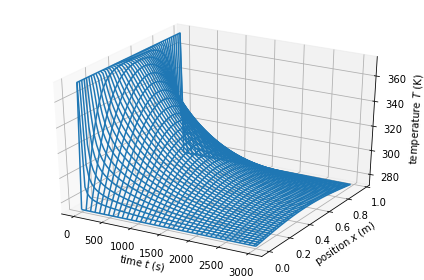

In [14]:
T_plot, (Dx, Dt, step) = CrankNicholson_banded_T(t_max=3000, Dx=0.02, Dt=2)
plot_T(T_plot, Dx, Dt, step)

## Benchmarking

In [15]:
%timeit CrankNicholson_banded_T(t_max=3000, Dx=0.002, Dt=2, verbose=False)

159 ms ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit CrankNicholson_T(t_max=3000, Dx=0.002, Dt=2, verbose=False)

13.7 s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


For the original problem, `np.linalg.solve()` is at least as fast as the banded solution, but for 10 times smaller step size (from 0.02 to 0.002) ie from 100 x 100 to 1000 x 1000 matrix, the slow-down is about

In [20]:
13.7/0.159

86.16352201257861

The inverse matrix is very competitive for this problem size but will run into limitations for larger sizes.

In [18]:
%timeit CrankNicholson_inverse_T(t_max=3000, Dx=0.002, Dt=2, verbose=False)

205 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Tridiagonal matrix algorithm
The usual way to solve the matrix problem is to use a special algorithm for tridiagonal matrices, the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm). This can be done in $\mathcal{O}(N)$ and thus is *as fast as the simple iterative scheme*! 

Implementation of the Thomas algorithm in Python is not difficult (see, for instance, cdhagman's answer [Stackoverflow: Optimize A*x = B solution for a tridiagonal coefficient matrix](http://stackoverflow.com/a/23133208)).

In [19]:
# left as an exercise